In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import euclidean_distances
import copy

In [2]:
# 1. import data
X, y = make_blobs(n_samples=100)
X.shape, y.shape

((100, 2), (100,))

In [3]:
# 2. calculate Similarity Matrix, equation (1), (2)
def cal_Similarity(X, preference):
    S = -euclidean_distances(X, X)
    if preference == 'min':
        preference = np.min(S)
    else:
        preference = np.median(S)
    np.fill_diagonal(S, preference)
    return S

In [4]:
# 3. calculate Responsity Matrix, equation (3)
# 3.1 find max{a_ik'+s_ik'}, k' != k
def cal_largest_criterion_except_k(S, A):
    n = S.shape[0]
    row_index = np.arange(n)
    
    C = A + S
    max_index_each_row = np.argmax(C, axis=1)
    
    C_copy = copy.deepcopy(C)
    # replace the max value to -np.inf to find the second max value
    C_copy[row_index, max_index_each_row] = -np.inf
    second_max_index_each_row = np.argmax(C_copy, axis=1)

    # get the max value for each row
    max_value_each_row = C[row_index, max_index_each_row]
    # get the second max value for each row
    second_max_value_each_row = C[row_index, second_max_index_each_row]
    
    R_to_substract = np.zeros(shape=(n, n))
    R_to_substract[row_index] = max_value_each_row.reshape(-1, 1)
    R_to_substract[row_index, max_index_each_row] = second_max_value_each_row
    return R_to_substract

def cal_Responsity(S, A):
    R_to_substract = cal_largest_criterion_except_k(S, A)
    return S - R_to_substract

In [5]:
# 4. cal Availability Matrix A, equation (5),(6)
def cal_Availability(S, R):
    n = S.shape[0]
    R_dia = R.diagonal()
    
    R_ramp = np.maximum(R, 0)
    R_ramp_dia = R_ramp.diagonal()
    R_ramp_sum = np.sum(R_ramp, axis=0)
    
    # a(i, k) = min{0, R(k, k) + R_ramp_sum[k] - R_ramp(i, k) - R_ramp(k, k)}
    A = -R_ramp - R_ramp_dia + R_dia + R_ramp_sum
    A = np.minimum(A, 0)
    
    # fill the diagonal with a(k, k) = sum_{i'!=k} max{0, r(i', k)}
    R_ramp_copy = copy.deepcopy(R_ramp)
    # fill diagonal with 0 to exculde
    np.fill_diagonal(R_ramp_copy, 0)
    A_dia = np.sum(R_ramp_copy, axis=0)
    
    np.fill_diagonal(A, A_dia)
    return A

In [6]:
# 5. find exemplars
    # for each the max value of c(i, k)
    # either identifies point i as an exemplar if k = i,
    # or identifies the data point that is the exemplar for point i
    # also, exemplars equal to the points whoese diagonal value > 0, that is
    # exemplars = row_index[C.diagonal() > 0]
def cal_exemplars(C):
    n = C.shape[0]
    row_index = np.arange(n)
    max_index_each_row = np.argmax(C, axis=1)
    exemplars = row_index[row_index == max_index_each_row]
    return exemplars

In [7]:
# 6. find labels
    # for each the max value of c(i, k)
    # either identifies point i as an exemplar if k = i,
    # or identifies the data point that is the exemplar for point i
def cal_labels(C_res, exemplars_res):
    n = C_res.shape[0]
    row_index = np.arange(n)
    max_index_each_row = np.argmax(C_res, axis=1)
    k = exemplars_res.shape[0]
    labels = np.zeros(shape=(n, ))
    for i in range(k):
        exemplar = exemplars_res[i]
        cluster = row_index[max_index_each_row == exemplar]
        labels[cluster] = i
    return labels

In [8]:
# 7. Put together
    # import note: use the damped R to update A!!!
    # the paper didn't mention that
def ap(X, preference, damping, max_iter, stop_iter):
    n = X.shape[0]
    # 1. calculate Similarity
    S = cal_Similarity(X, preference)
    # 2. init Availabiliy, Responsibility to zeros
    A = np.zeros(shape=(n, n))
    R = np.zeros(shape=(n,n))
    C = R + A
    exemplars = cal_exemplars(C)
    accum_count = 0
    left_iter = max_iter
    while left_iter > 0:
        # 3. calculate Responsity, Availability
        R_updated = cal_Responsity(S, A)
        # Damping First! Very Important! Or May Not Converge
        R = damping*R + (1-damping)*R_updated
        
        A_updated = cal_Availability(S, R)
        A = damping*A + (1-damping)*A_updated
        
        C_updated = R + A
        exemplars_updated = cal_exemplars(C_updated)
        
        num = exemplars.shape[0]
        num_updated = exemplars_updated.shape[0]
        
        if num > 0 and (num == num_updated) and np.allclose(exemplars, exemplars_updated):
            accum_count += 1
            if accum_count == stop_iter:
                labels = cal_labels(C_updated, exemplars_updated)
                print('Converge at iter', max_iter - left_iter)
                return labels, exemplars_updated
        exemplars = exemplars_updated
        C = C_updated
        left_iter -= 1
    print('Not converge.')
    return np.array([-1]*n), []

In [9]:
# 8. Compare and Show Results
# 8.1 with median preference
labels_median, cluster_centers_median = ap(X, 'median', 0.5, 100, 20)

Converge at iter 29


In [10]:
# 8.2 with min preference
labels_min, cluster_centers_min = ap(X, 'min', 0.5, 100, 20)

Converge at iter 41


In [11]:
# 8.3 Sklearn
from sklearn.cluster import AffinityPropagation
ap_sklearn = AffinityPropagation(random_state=42).fit(X)
labels_sklearn = ap_sklearn.labels_
cluster_centers_sklearn = ap_sklearn.cluster_centers_indices_

In [12]:
def plot_scatter(ax, X, labels, title):
    ax.scatter(X[:, 0], X[:, 1], c=labels)
    ax.set_title(title)

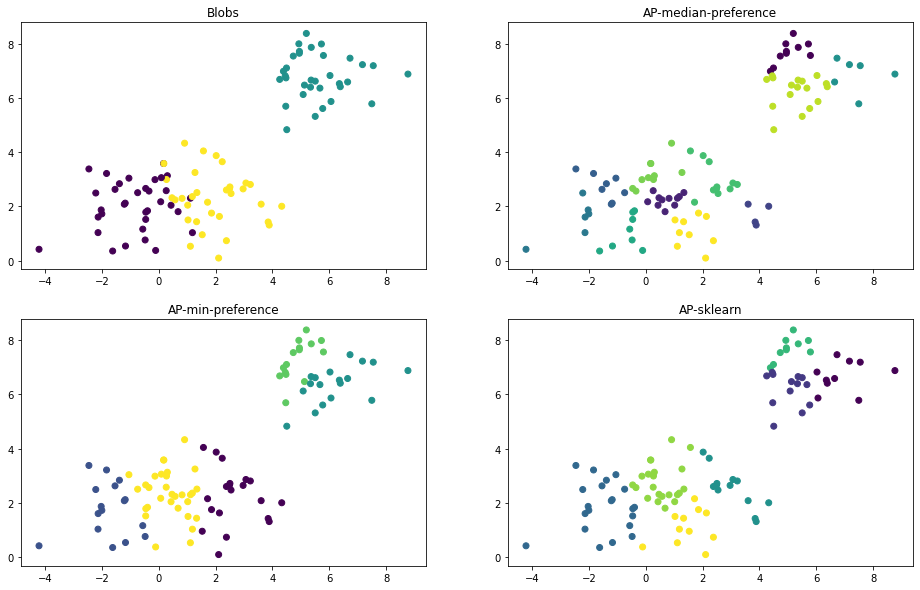

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
plot_scatter(axes[0, 0], X, y, 'Blobs')
plot_scatter(axes[0, 1], X, labels_median, 'AP-median-preference')
plot_scatter(axes[1, 0], X, labels_min, 'AP-min-preference')
plot_scatter(axes[1, 1], X, labels_sklearn, 'AP-sklearn')